# Intermediate Machine Learning: Intro to CNNs

# The Dataset

We will be using the CIFAR-10 dataset.  This is a dataset of small color images with 10 different categories of objects.  It is a subset of the larget CIFAR-100 dataset.  The categories are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  There are 5000 images of each category.

It was first introduced in the paper: [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), by Alex Krizhevsky, 2009.   The data was acquired from [Kaggle](https://www.kaggle.com/datasets/swaroopkml/cifar10-pngs-in-folders)

Here are some samples images: 

![Sample Images](https://storage.googleapis.com/kaggle-media/competitions/kaggle/3649/media/cifar-10.png)


# The Business Problem

Our task is to create a computer vision model that can ingest an image in one of these 10 categories and accurately classify it.  

# Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import glob

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, callbacks

# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

# Custom Functions

In [26]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f",
                           class_labels=None):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0],
                                           display_labels=class_labels);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=class_labels);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_labels)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    
    return results_dict



## Data Exploration

Let's take a look at the files we have to use to train and validate our model.  We will start by creating lists of paths to each folder.

In [3]:
# examine folders 
folder = 'Data/cifar10/'

train_folders = glob.glob(folder + 'train/*')
test_folders = glob.glob(folder + 'test/*')
display('training folders', train_folders)
print()
display('testing folders', test_folders)

'training folders'

['Data/cifar10/train\\airplane',
 'Data/cifar10/train\\automobile',
 'Data/cifar10/train\\bird',
 'Data/cifar10/train\\cat',
 'Data/cifar10/train\\deer',
 'Data/cifar10/train\\dog',
 'Data/cifar10/train\\frog',
 'Data/cifar10/train\\horse',
 'Data/cifar10/train\\ship',
 'Data/cifar10/train\\truck']

'testing folders'

['Data/cifar10/test\\airplane',
 'Data/cifar10/test\\automobile',
 'Data/cifar10/test\\bird',
 'Data/cifar10/test\\cat',
 'Data/cifar10/test\\deer',
 'Data/cifar10/test\\dog',
 'Data/cifar10/test\\frog',
 'Data/cifar10/test\\horse',
 'Data/cifar10/test\\ship',
 'Data/cifar10/test\\truck']

Now let's grab the paths to the training images so we can explore them.

In [4]:
# get image file names

train_imgs = glob.glob(folder + '/train/*/*')
train_imgs[:5]

['Data/cifar10//train\\airplane\\0001.png',
 'Data/cifar10//train\\airplane\\0002.png',
 'Data/cifar10//train\\airplane\\0003.png',
 'Data/cifar10//train\\airplane\\0004.png',
 'Data/cifar10//train\\airplane\\0005.png']

## Examine One Image

A good place to start in exploring image data is to look at a few.

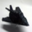

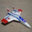

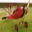

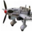

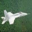

In [5]:
# load and view five images from the training images
for image in train_imgs[:5]:
    img_loaded = load_img(image)
    display(img_loaded)

Next, let's examine the shape and the values of the array representation of the image.

In [6]:
## Examine shape and values of loaded image
img_array = img_to_array(img_loaded)
image_shape = img_array.shape
print(image_shape)
img_array

(32, 32, 3)


array([[[ 44.,  73.,  49.],
        [ 47.,  77.,  53.],
        [ 51.,  81.,  57.],
        ...,
        [ 75., 107.,  83.],
        [ 72., 104.,  80.],
        [ 74., 106.,  82.]],

       [[ 52.,  85.,  55.],
        [ 47.,  79.,  54.],
        [ 51.,  82.,  60.],
        ...,
        [ 73., 105.,  81.],
        [ 74., 106.,  82.],
        [ 76., 108.,  84.]],

       [[ 65., 100.,  67.],
        [ 57.,  91.,  65.],
        [ 54.,  87.,  66.],
        ...,
        [ 73., 105.,  81.],
        [ 73., 105.,  81.],
        [ 75., 108.,  82.]],

       ...,

       [[ 56.,  82.,  48.],
        [ 49.,  75.,  41.],
        [ 49.,  74.,  41.],
        ...,
        [ 53.,  77.,  49.],
        [ 52.,  77.,  48.],
        [ 53.,  77.,  49.]],

       [[ 41.,  64.,  35.],
        [ 56.,  79.,  50.],
        [ 52.,  75.,  46.],
        ...,
        [ 52.,  74.,  49.],
        [ 52.,  74.,  49.],
        [ 49.,  72.,  46.]],

       [[ 24.,  44.,  19.],
        [ 49.,  69.,  44.],
        [ 40.,  

# Data Preparation: 

## Create Tensorflow Dataset

Now that we have a sense of what we have, let's set up our Tensorflow Dataset.  Remember, this is an ETL pipeline that will load batches of images from our disk into memory and use those to train the model.

This is important because we may not have enough computer memory to hold all of the images at the same time.  Instead, we just load a few, train the model on them, remove them from working memory, and then load the next batch.

Since accessing long-term computer storage is slower than accessing working memory (RAM), we will set our Dataset object to prefetch and cache the images to improve the speed at which it's able to deliver them to the model.

In [7]:
# Define some variables for later use

batch_size = 32
img_height = image_shape[0]
img_width = image_shape[1]

In [8]:
# Create a Dataset object to stream images from the file folders.

# Training Dataset
ds_train = tf.keras.utils.image_dataset_from_directory(
    folder + '/train',
    shuffle=True,
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Validation and testing sets
ds_val, ds_test = tf.keras.utils.image_dataset_from_directory(
    folder + '/test',
    validation_split = .5, #split the testing data into validation and test sets
    subset='both',
    shuffle=True,
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)
    

Found 50000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Using 5000 files for training.
Using 5000 files for validation.


## Create a dictionary of class names

The Dataset object will one-hot encode the classes, so it will be challenging to determine which class is actually being predicted by the model.

We can create a dictionary of class names to help us look up the string representation of the one-hot encoded class.

We have to do this before we optimize the dataset in the next step

In [9]:
# Get the class names and the number of classes
class_names = ds_train.class_names
num_classes = len(class_names)

# Create a dictionary we can use to lookup the class names.

class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Retrieve an element to make sure the dataset object is working correctly.

We will extract one batch of images and labels and display just the first one.  We will use our `class_dict` to lookup the string name of the class label, since it is returned as a one-hot encoded array.

bird


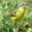

(32, 32, 3)


In [14]:
# Get one batch of images from the training set
example_imgs, example_labels= ds_train.take(1).get_single_element()
img = example_imgs[0]
label = example_labels[0]
input_shape = img.shape

## Lookup the string name of the label and display both the label and the image
label = class_dict[np.argmax(label)]
print(label)
display(array_to_img(img))
print(input_shape)

## Optimize Datasets for performance

Next we will optimize our Datasets for performance.  They will load a new batch of images into memory while the model is training on the previous batch.  They will also cache images in a way that they can be more quickly accessed.

We will use AUTOTUNE to find the optimal number of batches to prefetch and set a buffer size as large as our dataset.

We will also shuffle the data.  We need to set an appropriate buffer size for the shuffling because Tensorflow needs to load in all the data to be shuffled.  If the total number of training images is larger than our working memory (RAM), then we cannot buffer them all.  However, if they CAN all be loaded into memory, then we want to do that so we get the most uniform shuffling possible.

Buffer size is a value that is really specific to the machine you are using.  If you get an OOM (out of memory) error, then try reducing your buffer size.

In this case our images are small and they will all fit in our memory (hopefully!) so we will set the buffer size to the full size of the Dataset.

In [11]:
# Set the datasets to cache and prefetch the data.  We will also have the training batches data shuffle each time they are used.

# find the optimal size for caches based on available memory
AUTOTUNE = tf.data.AUTOTUNE

# Set training data to cache, prefect, and shuffle
ds_train = ds_train.cache().shuffle(buffer_size=len(ds_train),
                                    seed=42).prefetch(buffer_size=AUTOTUNE)

# Set validation and testing data to cache and prefetch.  There's no reason to shuffle them.
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

We are ready to model the data.  

We will start with a rescaling layer to adjust the image values from a range of 0 to 255 to a range of 0 to 1.  This helps speed up learning for our model.

Then we will add convolutional layer and a pooling layer.

After those we will flatten the data with a flatten layer to prepare it for the dense output layer.

The output layer will have the same number of units as the number of classes and an softmax activation function.

This will be a very simple model, and is unlikely to fit the data very well.

It is best practice to create a function to generate the model.  This practice is good in case we want to tune it later.

In [31]:
## Default model building function
def build_default_model():
    # Build the model
    model = models.Sequential()

    model.add(layers.Rescaling(1/255, input_shape=input_shape))
    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=3))
    model.add(layers.Flatten()) # Don't forget to flatten!
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    display(model.summary())

    return model

Now let's build and fit the model!  Notice how few weights there are to train in the convolutional layer.

In [32]:
default_model = build_default_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3200)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                32010     
                                                                 
Total params: 32906 (128.54 KB)
Trainable params: 32906 (128.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________

None

In [33]:
## Fit the model

history = default_model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=25,
                    callbacks=[callbacks.EarlyStopping(patience=3)])

Epoch 1/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.5472 - accuracy: 0.4623 - val_loss: 1.3686 - val_accuracy: 0.5194
Epoch 2/25
1563/1563 [==============================] - 20s 13ms/step - loss: 1.2994 - accuracy: 0.5537 - val_loss: 1.2706 - val_accuracy: 0.5586
Epoch 3/25
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1904 - accuracy: 0.5919 - val_loss: 1.1928 - val_accuracy: 0.5934
Epoch 4/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.1197 - accuracy: 0.6192 - val_loss: 1.1388 - val_accuracy: 0.6042
Epoch 5/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0742 - accuracy: 0.6333 - val_loss: 1.0987 - val_accuracy: 0.6296
Epoch 6/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0422 - accuracy: 0.6441 - val_loss: 1.1063 - val_accuracy: 0.6224
Epoch 7/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0213 - accuracy: 0.6529 - val_loss: 1.0924 -

## Evaluate the Model


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.75      0.66      0.70      5000
  automobile       0.81      0.81      0.81      5000
        bird       0.56      0.62      0.59      5000
         cat       0.55      0.56      0.55      5000
        deer       0.68      0.62      0.65      5000
         dog       0.63      0.58      0.60      5000
        frog       0.67      0.83      0.74      5000
       horse       0.79      0.73      0.76      5000
        ship       0.78      0.78      0.78      5000
       truck       0.79      0.80      0.80      5000

    accuracy                           0.70     50000
   macro avg       0.70      0.70      0.70     50000
weighted avg       0.70      0.70      0.70     50000



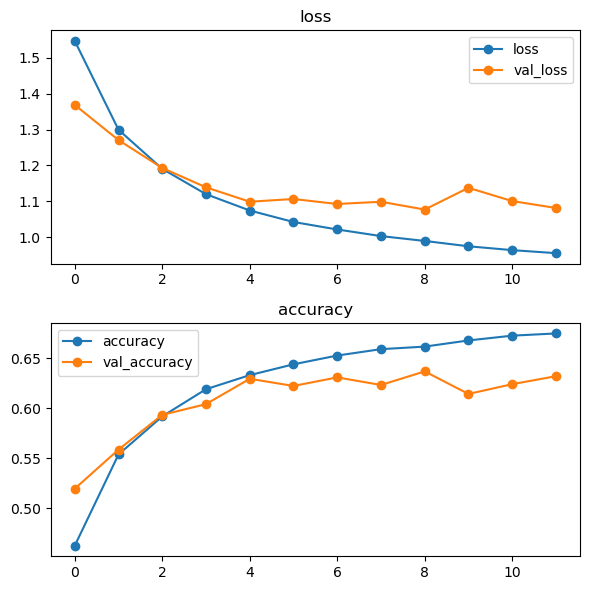

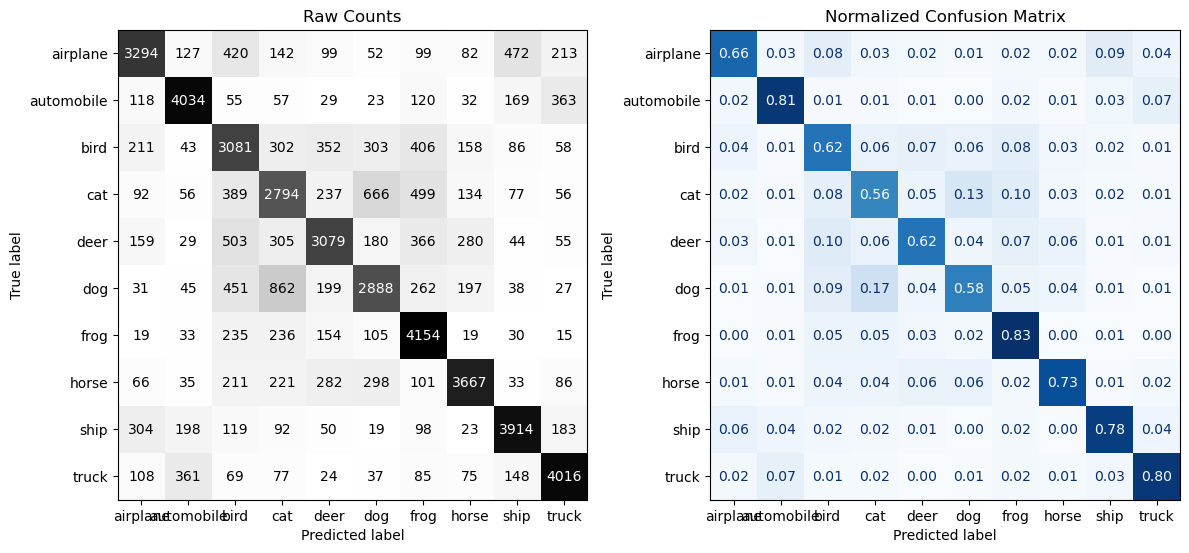


- Evaluating Training Data:
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9025 - accuracy: 0.6984
{'loss': 0.9025492072105408, 'accuracy': 0.698419988155365}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.65      0.61      0.63       474
  automobile       0.75      0.76      0.76       477
        bird       0.51      0.52      0.52       509
         cat       0.48      0.46      0.47       511
        deer       0.59      0.53      0.55       465
         dog       0.55      0.51      0.53       515
        frog       0.62      0.80      0.70       504
       horse       0.75      0.71      0.73       532
        ship       0.76      0.75      0.75       495
       truck       0.72      0.73      0.73       518

    accuracy                           0.64    

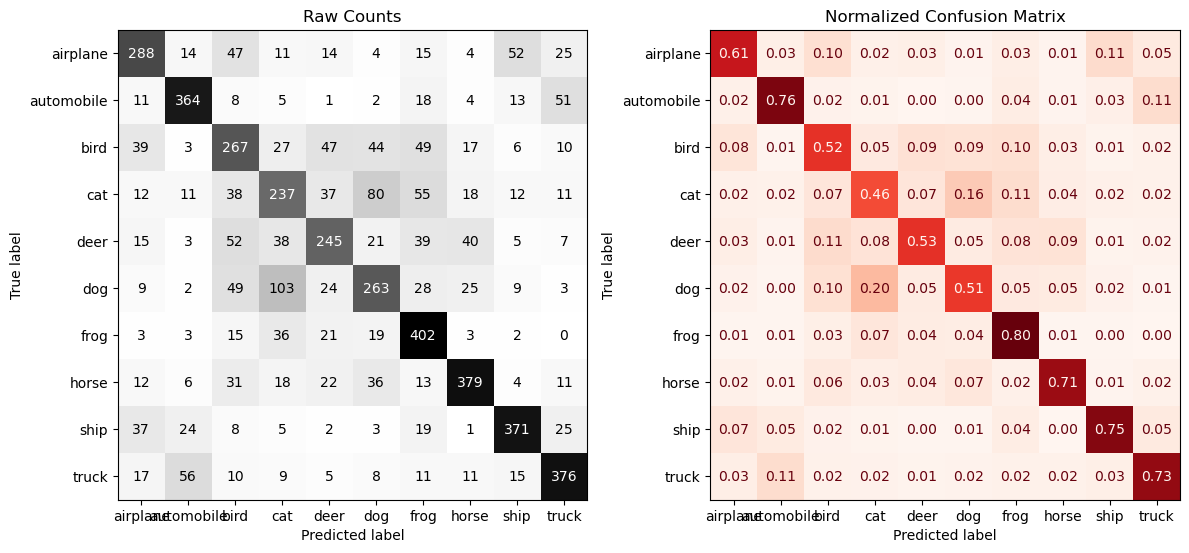


- Evaluating Test Data:
157/157 [==============================] - 1s 5ms/step - loss: 1.0706 - accuracy: 0.6384
{'loss': 1.0705885887145996, 'accuracy': 0.6384000182151794}


In [34]:
eval_dict = evaluate_classification_network(default_model, X_train=ds_train, X_test=ds_test, history=history,
                                           figsize=(12,8), class_labels=class_names)

Our model is not perfect, but it's much better than random chance!  With 10 equally sized classes a baseline accuracy would be 10%.  However, our model achieved a much higher score than that.

We did notice that our model was beginning to overfit, so some regularization might help that.  

The model also learned relatively slowly.  We could consider increasing the complexity of the model as well.  We could add more convolutional and pooling layers, and/or we could add more dense layers at the bottom.

# Summary

In this notebook you learned how to load and explore image files.  You also learned how to create, optimize, and use TensorFlow Dataset objects to stream, transform, and load data into a model.  You learned how to use convolutional and pooling layers to construct a simple image classifier that classified images into 10 different classes with 64% accuracy